# Usage with examples

In [1]:
%matplotlib inline 
import numpy as np
import pandas as pd
import pyhecdss

## Setting message level and program name

The HEC-DSS libraries output messaging to the console. To set the logging level of those libraries use the `set_message_level(int)` method



In [2]:
pyhecdss.set_message_level(10) # highest level with debug level of output
pyhecdss.set_message_level(0) # quiets messages to only aborts

The program name can be set which inserts the name in the meta information for the file on writes only

In [3]:
pyhecdss.set_program_name('PYTHON') # name used when writing to DSS files

The version supported by the native heclib is printed out here. pyhecdss is linked with version 6

In [4]:
fname=r'sample.dss'
print('Version of DSS file ',fname,': ',pyhecdss.get_version(fname)) # version of DSS file format as a string and integer tuple

Version of DSS file  sample.dss :  ['6-VE', 6]


## Example of writing a DSS File

This notebook is an example of how to interact with the features of pyhecdss
pyhecdss is a C-Python interface to HECLIB and in particular HECDSS. The plan is to only support reading regular and irregular time series into pandas DataFrame structure.

## Opening and closing a DSS File

Use the with statement as it takes care of closing the file handle and other resources

In [5]:
fname=r'sample.dss'
with pyhecdss.DSSFile(fname) as d:
    d.close()

## A regular time series

Create a pandas DataFrame of a sin wave and then write it out a pathname.

The concepts of regular time series is defined in HEC-DSS documentation. I would direct you there. There a limited number of period intervals supported by HEC-DSS formats. 

In addition to the pathname concept (pathnames consist of 6 parts A-F represented in a path like format /A/B/C/D/E/F/) the DSS format also stores units and the type of period (instantaneous or period and value or average as INST-VAL, PER-AVG, PER-VAL). 


### Create a new dataframe 

A dataframe with single column of values in the first column and indexed by datetime is what is required for HEC-DSS libraries for storage. It is limited to 1-dimensional time series

In [6]:
sina=np.sin(np.linspace(-np.pi, np.pi, 201))
dfr=pd.DataFrame(sina,index=pd.date_range('01jan1990 0100',periods=len(sina),freq='15T'))
dfr.head()

,0
1990-01-01 01:00:00,-1.224647e-16
1990-01-01 01:15:00,-3.141076e-02
1990-01-01 01:30:00,-6.279052e-02
1990-01-01 01:45:00,-9.410831e-02
1990-01-01 02:00:00,-1.253332e-01


Writing out this in-memory dataframe to a dss file requires defining the 
   * pathname (str, format of /A/B/C/D/E/F)
       * where the D part is reserved for timewindow
       * E part matches the time interval for a regular timeseries
   * units (str, e.g. 'CFS')
   * period_type (str one of INST-VAL or PER-*)

In [7]:
with pyhecdss.DSSFile(fname) as d:
    d.write_rts('/SAMPLE/SIN/WAVE//15MIN/SAMPLE1/',dfr,'UNIT-X','INST-VAL')

## An irregular time series

Create a pandas DataFrame and write it out as a pathname

Again very similar to the regular time series. For details on the concepts please refer to documentation for HEC-DSS


### Create an irregular time series

This is similar to the regular time series with the difference that there is no periodic frequency and so both values and index is specified by arrays. 

In [8]:
dfi=pd.DataFrame([1.5, 3.2, 2.7], index=pd.to_datetime(['01jan1990 0317', '09apr1991 0520', '05sep1992 2349']))

The additional values needed to write are the pathname, units and period-type. See the section on regular time series above for details

In [9]:
with pyhecdss.DSSFile(fname) as d:
    d.write_its('/SAMPLE/ITS1/RANDOM//IR-YEAR/SAMPLE2/',dfi,'YYY','INST-VAL')

## Reading DSS Files

After opening the dss file, the catalog is the first thing to read if you don't know what to expect. 
The catalog is read in as a dataframe of A-F parts

<font color='red'>NOTE: This version of DSS is limited to a single catalog across all cataloging on this machine</font>

In [10]:
# Catalog reading
with pyhecdss.DSSFile(fname) as d:
    catdf=d.read_catalog()
    display(catdf)

,T,A,B,C,F,E,D
0,T4,SAMPLE,ITS1,RANDOM,SAMPLE2,IR-YEAR,01JAN1990 - 01JAN1992
1,T4,SAMPLE,SIN,WAVE,SAMPLE1,15MIN,01JAN1990 - 01JAN1990


## Catalog filtering

The catalog dataframe from the read_catalog method can use the pandas DataFrame filtering/indexing features to create a filtered data frame. 

The filtered catalog can be then turned into a list of pathnames with `get_pathnames(dfcat)`

That list of pathnames can then be used to retrieve the data for each pathname

In [11]:
fdf1=catdf[(catdf.B=='ITS1') & (catdf.C=='RANDOM')]
display("Catalog filtered for B == 'ITS1' & C=='RANDOM'")
display(fdf1)
display("Catalog filtered for B == 'SIN'")
fdf2=catdf[catdf.B=='SIN']
display(fdf2.head())


"Catalog filtered for B == 'ITS1' & C=='RANDOM'"

,T,A,B,C,F,E,D
0,T4,SAMPLE,ITS1,RANDOM,SAMPLE2,IR-YEAR,01JAN1990 - 01JAN1992


"Catalog filtered for B == 'SIN'"

,T,A,B,C,F,E,D
1,T4,SAMPLE,SIN,WAVE,SAMPLE1,15MIN,01JAN1990 - 01JAN1990


## Reading Timeseries Data

The filtered catalog dataframe from the previous cell can be used with get_pathnames() to get a list of pathnames for that catalog dataframe. 

The read_its and read_ts function returns a DSSData tuple of (data, units, type) where the 
   * data is the dataframe of the data indexed by time
   * units is a string value e.g. cfs for flow
   * type is a string value of either INST-VAL or PER-* representing period values


In [12]:
with pyhecdss.DSSFile(fname) as d:
    plist1=d.get_pathnames(fdf1)
    dfr1,units1,ptype1=d.read_its(plist1[0])
    print('Units: %s'%units1, 'Period Type: %s'%ptype1)
    print('Sample values: ')
    display(dfr1.head())
    plist2=d.get_pathnames(fdf2)
    dfi1,units2,ptype2=d.read_rts(plist2[0])
    print('Sample values: ')
    display(dfi1.head())

Units: YYY Period Type: INST-VAL
Sample values: 


,/SAMPLE/ITS1/RANDOM/01JAN1990 - 01JAN1992/IR-YEAR/SAMPLE2/
1990-01-01 03:17:00,1.5
1991-04-09 05:20:00,3.2
1992-09-05 23:49:00,2.7


Sample values: 


,/SAMPLE/SIN/WAVE/01JAN1990 - 01JAN1990/15MIN/SAMPLE1/
1990-01-01 01:00:00,-1.224647e-16
1990-01-01 01:15:00,-3.141076e-02
1990-01-01 01:30:00,-6.279052e-02
1990-01-01 01:45:00,-9.410831e-02
1990-01-01 02:00:00,-1.253332e-01


## Closing DSS File
Closing the DSS File is important as multi user access is possible but might hang if the other thread is writing and holding on to an open handle

<font color=red>__Warning__ 
    Just use the "with" statement. 
    <br/>If you using open and close it is much better to use try: finally: close block</font>

In [13]:
try:
    d=pyhecdss.DSSFile(fname)
finally:
    d.close()

## Best way to work with DSS Files
Using context managers allows the cleanup of the open dss file handle without explicitly closing it.

In [14]:
with pyhecdss.DSSFile('sample.dss') as d:
    display(d.read_catalog())
# d is closed once out of the context of the with statement above

,T,A,B,C,F,E,D
0,T4,SAMPLE,ITS1,RANDOM,SAMPLE2,IR-YEAR,01JAN1990 - 01JAN1992
1,T4,SAMPLE,SIN,WAVE,SAMPLE1,15MIN,01JAN1990 - 01JAN1990


## Convenience methods for matching partnames

If you know the patterns of pathnames expected in the dss file and don't worry about the overhead of opening and closing dss files then the follow methods are quite convenient

<font color='green'> The get* methods are generators so if you don't know or don't have a large number of expected pathnames you can simply surround the method call with list() </font>

The [`get_ts`](../pyhecdss.html#pyhecdss.pyhecdss.get_ts)
See the returned tuple by the `get_ts` method consisting of :-
 * the dataframe
 * the units 
 * the period_type

In [15]:
for t in pyhecdss.get_ts('sample.dss','/SAMPLE/SIN/////'):
    display(t.data.head())
    print(t.units)
    print(t.period_type)

,/SAMPLE/SIN/WAVE/01JAN1990 - 01JAN1990/15MIN/SAMPLE1/
1990-01-01 01:00:00,-1.224647e-16
1990-01-01 01:15:00,-3.141076e-02
1990-01-01 01:30:00,-6.279052e-02
1990-01-01 01:45:00,-9.410831e-02
1990-01-01 02:00:00,-1.253332e-01


UNIT-X
INST-VAL


## Use regular expressions for more powerful filtering

Use `get_matching_ts` to filter the path parts (between //) as regular expressions to filter pathnames to retrieve data from.

This method also returns a generator of matching pathnames so surround with list() if you don't expect a large number returned


In [16]:
for t in pyhecdss.get_matching_ts('sample.dss','//.*/////'):
    display(t.data.head())
    print(t.units, t.period_type)

,/SAMPLE/ITS1/RANDOM/01JAN1990 - 01JAN1992/IR-YEAR/SAMPLE2/
1990-01-01 03:17:00,1.5
1991-04-09 05:20:00,3.2
1992-09-05 23:49:00,2.7


YYY INST-VAL


,/SAMPLE/SIN/WAVE/01JAN1990 - 01JAN1990/15MIN/SAMPLE1/
1990-01-01 01:00:00,-1.224647e-16
1990-01-01 01:15:00,-3.141076e-02
1990-01-01 01:30:00,-6.279052e-02
1990-01-01 01:45:00,-9.410831e-02
1990-01-01 02:00:00,-1.253332e-01


UNIT-X INST-VAL


## Plotting and other features
Once the data is available as a pandas DataFrame, all the features such as plotting and analysis is available through other libraries such as matplotlib (see example below)

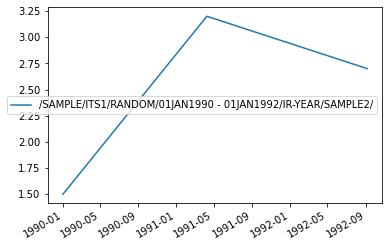

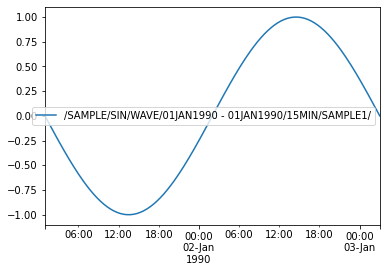

In [17]:
axes1=dfr1.plot()
axes2=dfi1.plot()